In [1]:
from tamkin import *
import numpy as np
import numpy
import re
import matplotlib.pyplot as plt
from adjustText import adjust_text
import os

import GPy
import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel

from GPyOpt.methods import BayesianOptimization
import GPyOpt

np.bool = bool

np.random.seed(20)

# Thermo Acquisition

This notebook introduces a thermodynamically inspired acquisition function. Gibbs (G = H - TS) and Helmholtz/ Free Energy (F = E - TS) serve as a starting point. Their main feature is that they consist of an energetic and an entropic part.

The approach is based on the dimensionless parts of energy and entropy as we cannot tell anything about the other parts. Maybe we dont need to start from an thermodynamic equation and just state that we add them up. Still, Im not sure if the whole thing is physically enough or really makes sense... but it works quite well...

In this we face and energy part and an entropy part. The aim is to transfer both into an acquisition function. Energy of a state enter Boltzmann weighted into subsequent investigations, while entropies enter as negative logarithmic probabilities of the underlying microstates. As one sample represents one microstate, only the weights/propabilities need to be considered. Besides sampling minimum energies (which is achieved through Boltzmann weighted Eneries), we also need to reduce the uncertainty which might be interpreted as a kind of entropy in our predictions. As normer we need to approximate Z as $1/\beta$ (mean of randomly distributed energies in $E_{range}$ because we dont know more. Instead we might compute Z and/or $E_{range}$ on the run). Or we state that the energy range is a reasonable normer for the energy part of the equation.

We simply add both parts and end up with:

$$ f_{aqui} =  \beta \cdot exp( - \beta m )  - p \log( p ) $$

$$  \frac{\partial f_{aqui}}{\partial x} =  -\frac{\partial m}{\partial x}~ exp( - \beta m )  + \frac{ log(2\pi v) - 2  }{ 4v \sqrt{2 \pi v} } \cdot \frac{\partial v}{\partial x} $$

with mean value $m$ of the Gaussian Process, variance $v$ of the Gaussian Process, Gaussian maximum propability $p = 1/\sqrt{2 \pi v}$ and $\beta = \frac{E_{range}}{ \text{RT}}$ because the energies are usually normed. $E_{range}$ is the energy range (either known or guessed) of the scan, R the gas constant and T the reference temperature.

Theres also a jitter (J) parameter i.e. a positive value to make the acquisition more explorative. This parameter usually represents some kind of noise added to mathematical operations. Here its just a weighting parameter for the entropic i.e. explorative part of the aquisition function. The default is one which leads to the functional forms above. If the parameter is not one it works as follows:

$$ f_{aqui} = \beta \cdot exp( - \beta m )  - \text{J} \cdotp \log( p ) $$

$$  \frac{\partial f_{aqui}}{\partial x} =  - \frac{\partial m}{\partial x}~ exp( - \beta m ) + \text{J} \cdot \frac{ log(2\pi v) - 2  }{ 4v \sqrt{2 \pi v} } \cdot \frac{\partial v}{\partial x} $$

Bayesian optimization uses maxima of the acquisition function to get new samples.



# Acquisition test without Multi-Fidelity

In this example notebook, the developed acquisition function is tested with a well-measured low fidelity example. The aim is to reveal the sampling behaviour and to analyse the error propagation for thermodynamic properties.


In [2]:
folder = "thermo_test_0"

try:
    os.mkdir(folder,)
except:
    print("folder exists... stuff might be overwritten")
    
if folder[-1] != "/":
    folder += "/"

folder exists... stuff might be overwritten


In [3]:

#######################
numlev=1000

####################
# Checking routine #
####################

def check1(fname, txt):
    F = open(fname, 'r')
    f = F.read()
    F.close()

    print( "" )
    print( "Checking routine:" )
    print( "File name:", F.name )

           #erg = re.search("CCSD\(T\)\=\s*(\-?\d+\.\d+)D([+-]\d+)",f)
    erg = re.search(txt,f)
    if erg == None:
        print( "CCSD(T) not found" )
    else:
        energy = float(erg.group(1))*10**float(erg.group(2))
        print( "CCSD(T) =", energy )

    return energy
    F.close()


R3HH_E2 = check1("scan_data/R3H+CH3_TS_CCSD-pvdz.log", "CCSD\(T\)\=\s*(\-?\d+\.\d+)D([+-]\d+)")
R3HH_E3 = check1("scan_data/R3H+CH3_TS_CCSD-pvtz.log", "CCSD\(T\)\=\s*(\-?\d+\.\d+)D([+-]\d+)")

#####################################
# Single point energies calculation #
#####################################

def specalc(E2,E3):
    a = (216.*(E2-E3))/(19)
    Einf2 = E2 - a/8.
    Einf3 = E3 - a/27.
    Einf = numpy.mean([Einf2,Einf3])
    print( "" )
    print( "Single point energies calculation with extrapolation scheme" )
    print( "a =", a )
    print( "Einf =", Einf )
    return a, Einf 

a, R3HH_Einf = specalc(R3HH_E2,R3HH_E3)
#################################################################################################



TS        = load_molecule_g03fchk("scan_data/R3H+CH3_TS_b2plypd3.fchk", energy=R3HH_Einf)
TS_scan1  = load_rotscan_g03log("scan_data/R3H+CH3_TS_B2scan01.log", top_indexes= [4] )
TS_scan2  = load_rotscan_g03log("scan_data/R3H+CH3_TS_B2scan02s.log", top_indexes= [0] )
TS_scan3  = load_rotscan_g03log("scan_data/R3H+CH3_TS_B2scan03.log", top_indexes= [1] )
TS_scan5  = load_rotscan_g03log("scan_data/R3H+CH3_TS_B2scan05.log", top_indexes= [8] )
TS_scan6  = load_rotscan_g03log("scan_data/R3H+CH3_TS_B2scan06.log", top_indexes= [5] )




Checking routine:
File name: scan_data/R3H+CH3_TS_CCSD-pvdz.log
CCSD(T) = -308.62003579000003

Checking routine:
File name: scan_data/R3H+CH3_TS_CCSD-pvtz.log
CCSD(T) = -308.90385874

Single point energies calculation with extrapolation scheme
a = 3.2266187999993665
Einf = -309.02336313999996


In [4]:
# test the approach for different scans :)
#example = TSrotor5
#example = e1rotor1
example          = TS_scan2

dihedral = ( example.potential[0].copy() )/np.pi*180
energy   = example.potential[1].copy()
print("samples:",energy.shape)

p = np.argsort( dihedral )
energy   = energy[p]
dihedral = dihedral[p]


dihedral = dihedral / 180

energy   = energy*2625.5002
energy_min = np.min(energy)
energy -= energy_min

"""
Here the energy is normalized.

based on the diff between minimum and maximum energy and
a reference temperature a beta_normer is determined that 
will be used later.

if the energy range is unknown it can be estimated roughly

"""
energy_normer = np.linalg.norm( energy, np.inf )
print("energy_normer",energy_normer,"KJ/mol")
beta = 1/(8.314472/1000*300)
print("RT", 1/beta)
beta_normer = energy_normer*beta
print("beta_normer", beta_normer)
energy = energy / energy_normer

dihedral = np.concatenate((dihedral-2, 
                           dihedral, 
                        dihedral+2), axis=0)
energy   = np.tile( energy, 3)


samples: (25,)
energy_normer 23.839652087073773 KJ/mol
RT 2.4943416
beta_normer 9.557492881918728


In [5]:
"""
train GP onto scan results
--> this GP represents our scan in the bayesian optimization tests
--> only means are used. instead a simple interpolation algorithm can be used
"""

kernel = GPy.kern.Matern32(1)
kernel = GPy.kern.RBF(1)
gp_model = GPy.models.GPRegression( np.atleast_2d( dihedral ).T, np.atleast_2d( energy ).T , kernel)
gp_model.Gaussian_noise.fix(0.0001)

gp_model.optimize_restarts(5)

gp_model

Optimization restart 1/5, f = 36.71210778063952
Optimization restart 2/5, f = 36.71210845991038
Optimization restart 3/5, f = -105.07093759276876
Optimization restart 4/5, f = 36.71210769369346
Optimization restart 5/5, f = -105.07093759276319


GP_regression.,value,constraints,priors
rbf.variance,0.1657124454497221,+ve,
rbf.lengthscale,0.19203361628745397,+ve,
Gaussian_noise.variance,0.0001,+ve fixed,


In [6]:
print(gp_model)


Name : GP regression
Objective : -105.07093759276876
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.1657124454497221  |      +ve      |        
  rbf.lengthscale          |  0.19203361628745397  |      +ve      |        
  Gaussian_noise.variance  |               0.0001  |   +ve fixed   |        


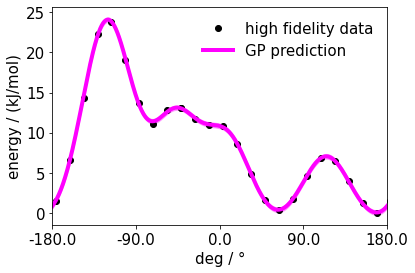

In [7]:
"""
visualize GP

this is the function to be explored and exploited
"""

msize=12 
fsize=15
alpha=0.3
lsize = 4

x_plot = np.atleast_2d( np.linspace(-1,1,1000) ).T
mean_gp_model, var_gp_model  = gp_model.predict(x_plot)
std_gp_model = np.sqrt(var_gp_model)

x_plot = np.squeeze(x_plot)
mean_gp_model = np.squeeze(mean_gp_model)*energy_normer
std_gp_model = np.squeeze(std_gp_model)*energy_normer


plt.plot( dihedral, energy*energy_normer, ".k",label="high fidelity data",markersize=msize)

plt.plot(x_plot, mean_gp_model,"-",label="GP prediction",color="magenta",linewidth=lsize)
plt.fill_between(x_plot, mean_gp_model-std_gp_model, mean_gp_model+std_gp_model,
                 alpha=alpha,color="magenta")

plt.xlim( (-1,1) )
plt.xlabel("deg / °",fontsize=fsize)
plt.ylabel("energy / (kJ/mol)",fontsize=fsize)
plt.xticks(np.linspace( min(x_plot), max(x_plot), 5) ,fontsize=fsize)    
plt.xticks( np.linspace( -1,1,5 )  ,np.linspace( -180, 180, 5) ,fontsize=fsize) 
plt.xlabel("deg / °",fontsize=fsize)
plt.yticks(fontsize=fsize)     
plt.legend(fontsize=fsize,frameon=False) #,loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.savefig(folder+"GP_on_data.png", bbox_inches='tight')
plt.savefig(folder+"GP_on_data.pdf", bbox_inches='tight')

In [8]:
"""

Here a Thermo inspired aquisition function is introduced

"""


from GPyOpt.acquisitions.base import AcquisitionBase
from GPyOpt.util.general import get_quantiles

class AcquisitionThermo(AcquisitionBase):
    """
    Thermo acquisition function

    :param model: GPyOpt class of model
    :param space: GPyOpt class of domain
    :param optimizer: optimizer of the acquisition. Should be a GPyOpt optimizer
    :param cost_withGradients: function
    :param jitter: positive value to make the acquisition more explorative.

    .. Note:: allows to compute the Improvement per unit of cost

    """

    analytical_gradient_prediction = True

    def __init__(self, model, space, beta=1.0, jitter=1.0, plot=False,
                 optimizer=None, cost_withGradients=None):
        self.optimizer = optimizer
        self.beta   = beta
        self.plot = plot
        super(AcquisitionThermo, self).__init__(model, space,optimizer=optimizer,
                                                   cost_withGradients=cost_withGradients)
        self.jitter = jitter

    @staticmethod
    def fromConfig(model, space,plot, optimizer, cost_withGradients, config):
        return AcquisitionThermo(model, beta=config['beta'], plot=plot,
                                    optimizer=optimizer, cost_withGradients=cost_withGradients,
                                    jitter=config['jitter'])

    def _compute_acq(self, x):
        """
        Computes Thermo acquisition function

        """
        m, v = self.model.predict(x)
        p    = 1/np.sqrt( 2*np.pi*v )
        lnp  = p*np.log( p )
        mb   = self.beta*np.exp( -m*self.beta )
        f_acqu = mb - self.jitter*lnp

        if np.sum( x.shape ) > 4 and self.plot:
            plt.plot(x,f_acqu,".",label="acq")
            plt.plot(x,mb,".",label="E")
            plt.plot(x,self.jitter*lnp,".",label="S")
            plt.legend()
            plt.show()
            plt.close()
        return f_acqu

    def _compute_acq_withGradients(self, x):
        """
        Computes Thermo acquisition function and its derivative (has a very easy derivative!)

        """
        m, v , dmdx, dvdx = self.model.predict_withGradients(x)
        p    = 1/np.sqrt( 2*np.pi*v )
        lnp  = p*np.log( p )
        mb   = self.beta*np.exp( -m*self.beta )
        f_acqu = mb - self.jitter*lnp

        dmb  = -dmdx*np.exp( -m*self.beta ) + self.beta*np.exp( -m*self.beta )
        dlnp = dvdx*( np.log( 2*np.pi*v ) - 2 )/ (4*np.sqrt(2*np.pi*v)*v )
        df_acqu = dmb + self.jitter*dlnp
        return f_acqu, df_acqu

"""
if you dont want to play around with it you can import this:

if you want to play around with AcquisitionThermo uncomment the following lines

"""    

import sys
sys.path.insert(0, '../tamkintools_multi_fidelity_bayesian/')
from thermoAQ import AcquisitionThermo

In [9]:
# x-range within bayesian opt takes place
xrange = (-1,1)

class GP_wrapper():
    """
    wrapper for a GP to be used as a model representation of QM scan results
    for bayesian optimization testing
    """
    def __init__(self, gp):
        self.gp = gp
        return
    def f(self,x):
        y, _ = self.gp.predict(np.atleast_2d(np.squeeze(x)).T)
        return np.squeeze(y)#+0.1
    #def f_var(self,x):
    #    return self.gp.predict(np.atleast_2d(np.squeeze(x)).T)
    
    
# initial inputs are generated here
# approach: a low number of equidistantly dirstributed initital samples
# the points are also increased in order to include the rotor characteristics in the optimisation
# ( there might be a feture in GPyOpt that supports rotors ?? )
x_sample = np.linspace(-1,1,5)
x_ini = np.atleast_2d(  np.unique( np.concatenate((x_sample-2, 
                           x_sample, 
                        x_sample+2), axis=0) ) ).T
y_ini, _  = gp_model.predict(x_ini)
y_sample, _  = gp_model.predict(  np.atleast_2d(x_sample).T  )
y_sample = np.squeeze(y_sample)   

# Based on: https://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/devel/manual/GPyOpt_constrained_optimization.ipynb
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': xrange}]

# Determine the subset where we are allowed to sample
feasible_region = GPyOpt.Design_space(space = domain) 
#initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, 4)

# CHOOSE the objective
stochastic_obj_func = GP_wrapper(gp_model).f
objective = GPyOpt.core.task.SingleObjective(stochastic_obj_func)

# CHOOSE the model type

# if theres any prior knowledge about the problem or data:
# add it here! (for example: noise)

# Matern32 kernel seems to be better suited for exploitation
#kernel = GPy.kern.Matern32(1)
#model = GPyOpt.models.GPModel(kernel=kernel,exact_feval=True,optimize_restarts=10,verbose=False)

# the more shaky default RBF kernel seems to be better suited for exploration
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=10,verbose=False)

# CHOOSE the acquisition optimizer
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)

# CHOOSE the type of acquisition. Here: AcquisitionThermo
# the values for 
# jitter:  1
# beta:  beta_normer
# based on our initial guess for the energy range work well for exploration
#acquisition = AcquisitionGibbs(model, feasible_region, optimizer=aquisition_optimizer,
#                                  jitter=0.5, beta=beta_normer, plot=True )
acquisition = AcquisitionThermo(model, feasible_region, optimizer=aquisition_optimizer,
                                  jitter=1.0, beta=beta_normer, plot=True )

# CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

# Now create BO object
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, 
                                                evaluator, x_ini, y_ini,normalize_Y=False)


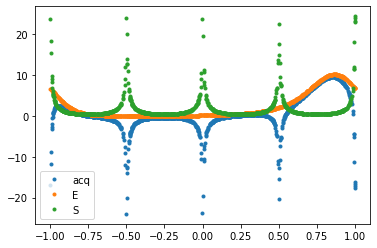

num acquisition: 1, time elapsed: 0.78s


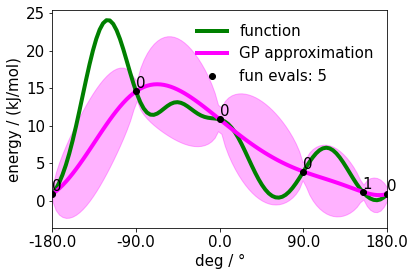


 STEP  0  DONE 
 
 



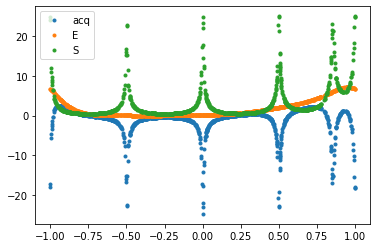

num acquisition: 1, time elapsed: 0.64s


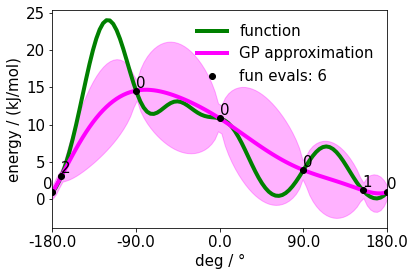


 STEP  1  DONE 
 
 



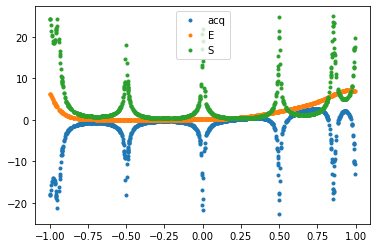

num acquisition: 1, time elapsed: 0.68s


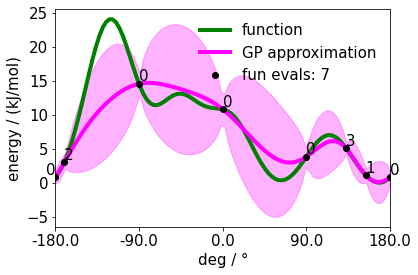


 STEP  2  DONE 
 
 



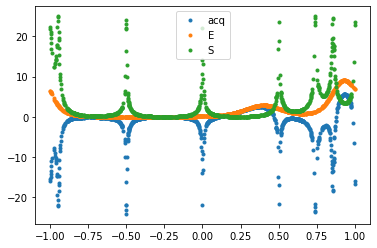

num acquisition: 1, time elapsed: 0.63s


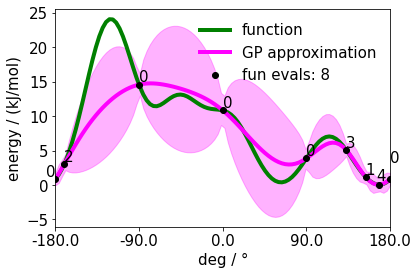


 STEP  3  DONE 
 
 



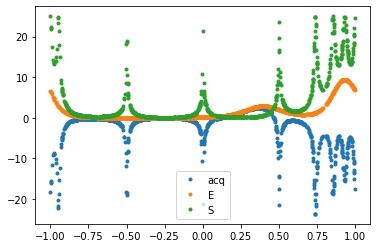

num acquisition: 1, time elapsed: 1.50s


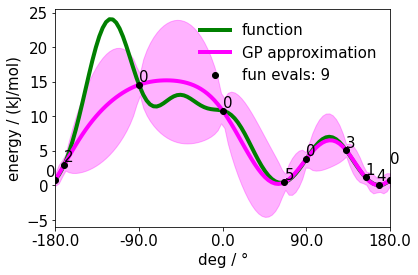


 STEP  4  DONE 
 
 



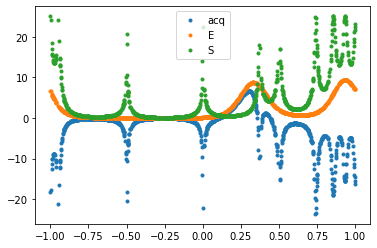

num acquisition: 1, time elapsed: 1.41s


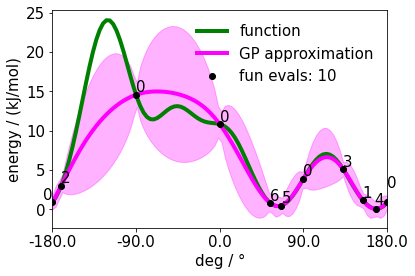


 STEP  5  DONE 
 
 



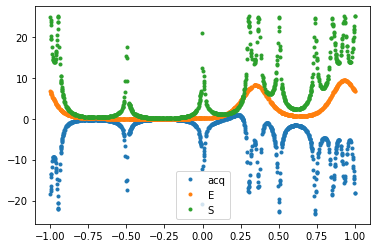

num acquisition: 1, time elapsed: 1.22s


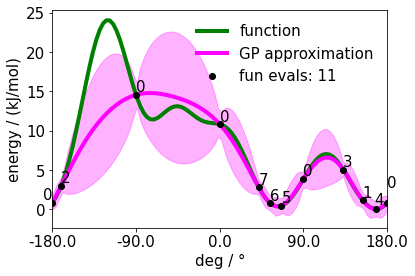


 STEP  6  DONE 
 
 



In [10]:
"""
change max_iter and compare thermo output to reference !!
"""

# --- Stop conditions
max_time  = None 
max_iter  = 7
tolerance = 1e-8     # distance between two consecutive observations 
                     # if we're sampling a region in such fine detail then it is likely that we've found the true min.

for iii in range(max_iter):    
    # Run the optimization                                                  
    bo.run_optimization(max_iter = 1, max_time = max_time, eps = tolerance, verbosity=True) 
    
    # plot optimization procedure
    bo_ins = bo.get_evaluations()[1].flatten()
    bo_outs = bo.get_evaluations()[0].flatten()

    #bo.plot_convergence()
    #print(bo.x_opt)
    #print(bo.fx_opt)

    """
    plot results :)
    """

    x = np.linspace(xrange[0],xrange[1],100)
    y = stochastic_obj_func(x)*energy_normer
    m, v = bo.model.predict( np.atleast_2d(x ).T )

    bo_evals, _ = bo.model.predict( np.atleast_2d(bo_outs).T )
    bo_evals = np.squeeze(bo_evals)*energy_normer
    y_evals = stochastic_obj_func( np.squeeze(bo_outs) )
    d0,d1 = np.polyfit( np.squeeze(bo_evals) , np.squeeze(y_evals) , 1 )
    m_normalized = np.squeeze(m)*energy_normer #*d0 + d1 
    v = np.squeeze(v)
    
    plt.plot(x,  y, label="function",linewidth=lsize, color = "green" )
    plt.plot(x, m_normalized, '-',label="GP approximation",linewidth=lsize,color="magenta")
    plt.fill_between(x, m_normalized-np.sqrt(v)*energy_normer,  m_normalized+np.sqrt(v)*energy_normer, 
                     alpha=alpha,color="magenta")
    
    bo_op = np.where( ( bo.X <= np.max(xrange) ) & ( bo.X >= np.min(xrange) ) )
    bo_oouts = bo.X[bo_op]
    bo_eevals = bo.Y[bo_op]*energy_normer
    plt.plot( bo_oouts , bo_eevals, ".k",markersize=msize ,label="fun evals: "+str( len(bo_eevals)-1 ))
    #plt.plot( bo_outs , bo_evals, ".k",markersize=msize ,label="fun evals: "+str( len(bo_eevals) ))

    ns = np.concatenate( (np.zeros(len(x_sample)), np.arange( len(bo_oouts)-len(x_sample) )+1  ))
    texts = []
    for i, n in enumerate(ns):
        texts.append(plt.text( bo_oouts[i], bo_eevals[i], str(int(n)), color="k",fontsize=fsize))
    adjust_text(texts, x=x, y=np.squeeze(m),
                only_move={'points':'xy', 'texts':'xy'},
                #arrowprops=dict(arrowstyle="->", color='r', lw=0.5),
                autoalign='xy',force_static=0.15,force_explode=0.1)


    plt.xlim(-1,1)
    plt.ylabel("energy / (kJ/mol)",fontsize=fsize)
    plt.xticks( np.linspace( -1,1,5 )  ,np.linspace( -180, 180, 5) ,fontsize=fsize)   
    plt.xlabel("deg / °",fontsize=fsize)
    plt.yticks(fontsize=fsize)     
    plt.legend(fontsize=fsize,frameon=False) #,loc='center left', bbox_to_anchor=(1.01, 0.5))
    plt.savefig(folder+"AcquisitionThermo_bayesian_opt"+str(iii)+".png", bbox_inches='tight')
    plt.savefig(folder+"AcquisitionThermo_bayesian_opt"+str(iii)+".pdf", bbox_inches='tight')    
    plt.show()
    plt.close()
    
    print("\n STEP ",str(iii)," DONE \n \n \n")
    

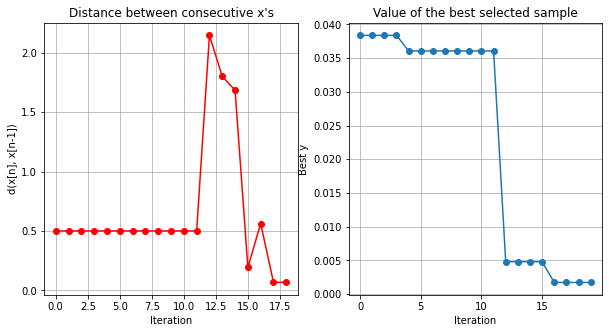

[0.93159496]
0.001722273844353765


In [11]:
# plot optimization procedure
bo_ins = bo.get_evaluations()[1].flatten()
bo_outs = bo.get_evaluations()[0].flatten()

bo.plot_convergence()
print(bo.x_opt)
print(bo.fx_opt)

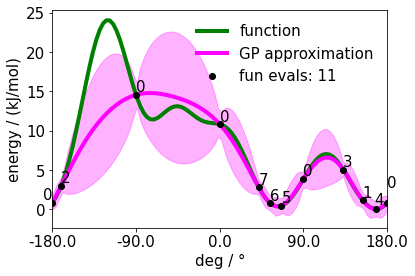

In [16]:
"""
plot results :)
"""

x = np.linspace(xrange[0],xrange[1],100)
y = stochastic_obj_func(x)
m, v = bo.model.predict( np.atleast_2d(x ).T )

bo_evals, _ = bo.model.predict( np.atleast_2d(bo_outs).T )
bo_evals = np.squeeze(bo_evals)
y_evals = stochastic_obj_func( np.squeeze(bo_outs) )
d0,d1 = np.polyfit( np.squeeze(bo_evals) , np.squeeze(y_evals) , 1 )
m_normalized = np.squeeze(m)*energy_normer #*d0 + d1 
v = np.squeeze(v)

#plt.plot(x,  (y-l0)/dl , label="function",linewidth=lsize, color = "green" )
plt.plot(x,  y*energy_normer, label="function",linewidth=lsize, color = "green" )
plt.plot(x, m_normalized, '-',label="GP approximation",linewidth=lsize,color="magenta")
#plt.plot(x, m_normalized-1.96*np.sqrt(v)*d0, '-', alpha=alpha,linewidth=lsize,color="magenta")
#plt.plot(x, m_normalized+1.96*np.sqrt(v)*d0, '-', alpha=alpha,linewidth=lsize,color="magenta")
#plt.plot(x, m_normalized-np.sqrt(v)*d0, '-', alpha=alpha,linewidth=lsize,color="magenta")
#plt.plot(x, m_normalized+np.sqrt(v)*d0, '-', alpha=alpha,linewidth=lsize,color="magenta")
plt.fill_between(x, m_normalized-np.sqrt(v)*energy_normer,  m_normalized+np.sqrt(v)*energy_normer, 
                 alpha=alpha,color="magenta")

bo_op = np.where( ( bo.X <= np.max(xrange) ) & ( bo.X >= np.min(xrange) ) )
bo_oouts = bo.X[bo_op]
bo_eevals = bo.Y[bo_op]*energy_normer
plt.plot( bo_oouts , bo_eevals, ".k",markersize=msize ,label="fun evals: "+str( len(bo_eevals)-1 ))
#plt.plot( bo_outs , bo_evals, ".k",markersize=msize ,label="fun evals: "+str( len(bo_eevals) ))

ns = np.concatenate( (np.zeros(len(x_sample)), np.arange( len(bo_oouts)-len(x_sample) )+1  ))
texts = []
for i, n in enumerate(ns):
    texts.append(plt.text( bo_oouts[i], bo_eevals[i], str(int(n)), color="k",fontsize=fsize))
adjust_text(texts, x=x, y=np.squeeze(m),
            only_move={'points':'xy', 'texts':'xy'},
            #arrowprops=dict(arrowstyle="->", color='r', lw=0.5),
            autoalign='xy',force_static=0.15,force_explode=0.1)


plt.xlim(-1,1)
plt.xlabel("deg / °",fontsize=fsize)
plt.ylabel("energy / (kJ/mol)",fontsize=fsize)
plt.xticks( np.linspace( -1,1,5 )  ,np.linspace( -180, 180, 5) ,fontsize=fsize)   
plt.xlabel("deg / °",fontsize=fsize)
plt.yticks(fontsize=fsize)     
plt.legend(fontsize=fsize,frameon=False) #,loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.savefig(folder+"AcquisitionThermo_bayesian_opt.png", bbox_inches='tight')
plt.savefig(folder+"AcquisitionGibbs_bayesian_opt.pdf", bbox_inches='tight')

### the "thermodynamically inspired" acquisition function works suprisingly well :)

Results are quite robust against the jitter parameter i.e. the parameter plays no role i.e. a value of 1 is fine.

In general, the approach is explorative at the beginning and then becomes more and more exploitative in terms of minima. This behaviour is very advantageous for our problems. When the switch from exploration to exploitation takes place depends on the energy profile and its range.


#### Now we can test the impact of our approximation for thermodynamic properties


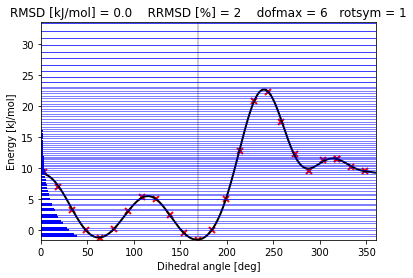

In [13]:
"""
full data example :)

these are the original data results (not useful here)
"""

nmaTS    = NMA(TS, ConstrainExt())
TSrotor1   = Rotor(TS_scan1, TS, cancel_freq='scan', rotsym=3, even=False, dofmax=6, num_levels = numlev)
TSrotor2   = Rotor(TS_scan2, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=6, num_levels = numlev)
TSrotor3   = Rotor(TS_scan3, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=7, num_levels = numlev)
TSrotor5   = Rotor(TS_scan5, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=6, num_levels = numlev)
TSrotor6   = Rotor(TS_scan6, TS, cancel_freq='scan', rotsym=3, even=False, dofmax=6, num_levels = numlev)

pfTS     = PartFun(nmaTS, [ExtTrans(), ExtRot(symmetry_number=1), TSrotor1, TSrotor2, TSrotor3, TSrotor5, TSrotor6])

ta_TS        = ThermoAnalysis(pfTS, [283,303,323,343,363,383,403,423,443,463])

ta_TS.write_to_file(folder+"test_thermodynamics_original.csv")
TSrotor2.plot_levels(folder+"RotorLevelsTest0_original.png",500, ) #num=500)


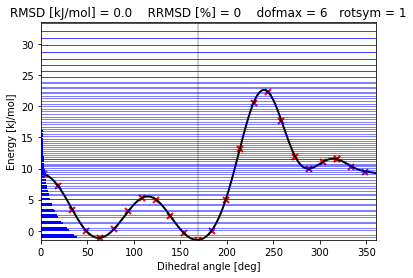

In [14]:
"""
reference data example :)

these are the reference data results
they are based on the GP approximation of the scan data
this approximation serves as BO reference function
... and therefore as benchmark for thermodynamic calculations

"""

dihedral_scan = ( example.potential[0].copy() )/np.pi

m_scan, _ = gp_model.predict( np.atleast_2d( dihedral_scan ).T )
m_scan = np.squeeze( m_scan )

example_scan  = load_rotscan_g03log("scan_data/R3H+CH3_TS_B2scan02s.log", top_indexes= [0] )


example_scan.potential[1] = ( m_scan* energy_normer + energy_min)  /2625.5002
example_rotor   = Rotor(example_scan, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=6, num_levels = numlev)


nmaTS      = NMA(TS, ConstrainExt())
TSrotor1   = Rotor(TS_scan1, TS, cancel_freq='scan', rotsym=3, even=False, dofmax=6, num_levels = numlev)
TSrotor2   = Rotor(TS_scan2, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=6, num_levels = numlev)
TSrotor3   = Rotor(TS_scan3, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=7, num_levels = numlev)
TSrotor5   = Rotor(TS_scan5, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=6, num_levels = numlev)
TSrotor6   = Rotor(TS_scan6, TS, cancel_freq='scan', rotsym=3, even=False, dofmax=6, num_levels = numlev)

example_pf     = PartFun(nmaTS, [ExtTrans(), ExtRot(symmetry_number=1), TSrotor1, example_rotor, TSrotor3, 
                           TSrotor5, TSrotor6])

example_ta   = ThermoAnalysis(example_pf, [283,303,323,343,363,383,403,423,443,463])

example_ta.write_to_file(folder+"test_thermodynamics_ref.csv")
example_rotor.plot_levels(folder+"RotorLevelsTest0_ref.png",500, ) #num=500)


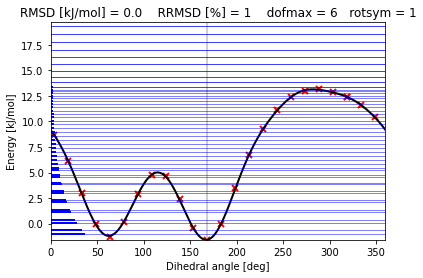

In [15]:
"""
reference data example :)

these are the BO results
this approximation serves as BO approximation of the reference function

"""

dihedral_scan = ( example.potential[0].copy() )/np.pi

m_scan, _ = bo.model.predict( np.atleast_2d( dihedral_scan ).T )
m_scan = np.squeeze( m_scan )

example_scan  = load_rotscan_g03log("scan_data/R3H+CH3_TS_B2scan02s.log", top_indexes= [0] )


example_scan.potential[1] = ( m_scan* energy_normer + energy_min)  /2625.5002
example_rotor   = Rotor(example_scan, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=6, num_levels = numlev)


nmaTS      = NMA(TS, ConstrainExt())
TSrotor1   = Rotor(TS_scan1, TS, cancel_freq='scan', rotsym=3, even=False, dofmax=6, num_levels = numlev)
TSrotor2   = Rotor(TS_scan2, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=6, num_levels = numlev)
TSrotor3   = Rotor(TS_scan3, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=7, num_levels = numlev)
TSrotor5   = Rotor(TS_scan5, TS, cancel_freq='scan', rotsym=1, even=False, dofmax=6, num_levels = numlev)
TSrotor6   = Rotor(TS_scan6, TS, cancel_freq='scan', rotsym=3, even=False, dofmax=6, num_levels = numlev)

example_pf     = PartFun(nmaTS, [ExtTrans(), ExtRot(symmetry_number=1), TSrotor1, example_rotor, TSrotor3, 
                           TSrotor5, TSrotor6])

example_ta   = ThermoAnalysis(example_pf, [283,303,323,343,363,383,403,423,443,463])

example_ta.write_to_file(folder+"test_thermodynamics_scan_"+str(int( len(bo_eevals)-1 ))+".csv")
example_rotor.plot_levels(folder+"RotorLevelsTest0_scan_"+str(int( len(bo_eevals)-1 ))+".png",500, ) #num=500)

